# This notebooks does predictive modeling of the Output : "Is there any cross Contact Allergens?" in the FSHA form 
# This notebook applies basic ML techniques like NaiveBayesClassifier, LogisticRegression, SGDClassifier on the concatenated text derived from the set of features. The text is cleaned, normalized and then vectorized and fit into the Model. The target is upsampled to counter the unbalanced data ('Yes' / 'No' values), before applying ML

In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
filename = "C:\\Users\\574977\\Downloads\\PycharmProjects\\pepsico\\shymal\Input files\\allergens/FSHA RPA - 25 July 2019 - 209Files.xlsm"
#filename1 = "C:/Pepsico/NAF-2019 RPA - 09 AUGUST 2019.xlsm"
#filename2 = "C:/Pepsico/NAF-2018 RPA - 09 AUGUST 2019.xlsm"
#filename3 = "C:/Pepsico/Additional FSHAs.xlsm"
#filename4 = "C:/Pepsico/FSHA RPA - Microbial Growth = Y - 14 Aug 2019.xlsm"
#filename4 = "C:/Pepsico/NAF - Additional FSHAs 1 - 13 AUG 2019.xlsm"

In [3]:
filename5 = "C:\\Users\\574977\\Downloads\\PycharmProjects\\pepsico\\shymal\Input files\\allergens/MLextracts_allergen 08 26.xlsm"

In [4]:
df_allergen_no = pd.read_excel(filename5)

In [5]:
df_allergen_yes = pd.read_excel(filename)

In [6]:
len(df_allergen_yes)

209

In [7]:
df_allergen_yes=df_allergen_yes[(df_allergen_yes['crossContactAllergens']=='Yes')]

In [8]:
len(df_allergen_yes)

203

In [9]:
len(df_allergen_no)

25

In [10]:
df = pd.concat([df_allergen_yes,df_allergen_no])

# Read the extract file, check the number of records, first few rows

# Select key features 

In [11]:
#features_df=df[['preservatives', 'pH', 'waterActivity', 'packaging','otherFSA',
#            'prodStorageDist', 'foodSafetyProdClaims','targetMarket','allergens','newIngredient','allergensLabeledIMAF']]
df.fillna('NA', inplace=True)
features_df=df[['allergens','allergensLabeledIMAF']]


In [12]:
def conv_str(x):
   
    x=str(x)
    x=x.lower()
    return (x)

features_df['allergens']=features_df['allergens'].apply(lambda x:conv_str(x))  
features_df['allergensLabeledIMAF']=features_df['allergensLabeledIMAF'].apply(lambda x:conv_str(x))

# Concatenate the columns as one single text value

In [13]:
features_df['concat_text'] = features_df['allergens']+" "+features_df['allergensLabeledIMAF']


# Find the number of tokens in the text

In [14]:
features_df['concat_text'].apply(lambda x: len(x.split(' '))).sum()

7174

We have over 7k words in the data.

# Find the value counts of target Field (Yes / No)

In [15]:
df.crossContactAllergens.value_counts()

Yes    203
No      25
Name: crossContactAllergens, dtype: int64

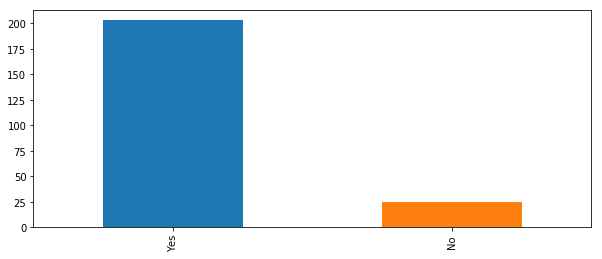

In [16]:
plt.figure(figsize=(10,4))
df.crossContactAllergens.value_counts().plot(kind='bar');

# Binarize the target, impute any missing value with the mode

In [17]:
import statistics 

def impute_target(fsha_data,targetName):
    train_y=[]
    for i in range (len(fsha_data)):
        if fsha_data[targetName].values[i]=='Yes':
            train_y.append(1)
        elif fsha_data[targetName].values[i]=='No':
            train_y.append(0)
        else:
            train_y.append(-1)
               
    mode_y = statistics.mode(train_y)

    for i in range (len(fsha_data)):
        if train_y[i]==-1:
            train_y[i] = mode_y
            
    return train_y

In [18]:
features_df["tags"] = impute_target(df,"crossContactAllergens")

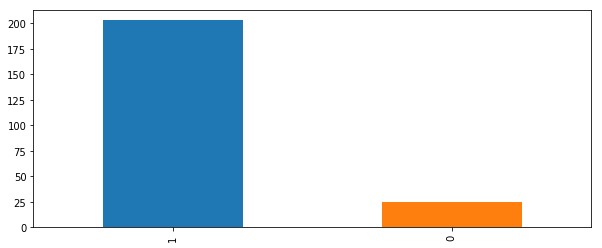

In [19]:
plt.figure(figsize=(10,4))
features_df.tags.value_counts().plot(kind='bar');

In [20]:
features_df.tags.value_counts()

1    203
0     25
Name: tags, dtype: int64

The classes are not balanced, but we see higher count of 1, based on new data

In [21]:
def print_plot(index):
    example = features_df[features_df.index == index][['concat_text', 'tags']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

# Have a look a few concatenated text and target pairs.

In [22]:
print_plot(10)

milk, soya, barley milk, lactose : milk, lactose : soya : milk, lactose : barley - no protein, no gluten)
Tag: 1


In [23]:
print_plot(5)

wheat starch, rusk from wheat from paprika seasoning, whey permeate wheat, gluten, milk, lactose
Tag: 1


# Clean the text (remove punctuation, symbols, lowercase etc)

In [24]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [25]:
features_df['concat_text'] = features_df['concat_text'].apply(clean_text)

# Check a sample row of cleaned text

In [26]:
print_plot(0)

allergens seasoningscq69 vegetable blend mccormick milk lactose2763030 cheese symrise milk lactosethe product may contain peanutexisting allergens manufacturing plant celery cereals containing gluten wheat barley oats milk mustard peanuts soyaexisting allergens production line celery cereals containing gluten wheat barley milk mustard peanuts soya milk lactose milk lactose
Tag: 1


In [27]:
features_df['concat_text'].apply(lambda x: len(x.split(' '))).sum()

3540

# Train Test Split

In [28]:
X = features_df.concat_text
y = features_df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state = 42)

In [29]:
y_train.value_counts()

1    162
0     20
Name: tags, dtype: int64

In [30]:
y_test.value_counts()

1    41
0     5
Name: tags, dtype: int64

In [31]:
y_test = y_test.reset_index()
y_test = y_test['tags']

# Upsample the target data, since the data is highly imbalanced

In [32]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_crossContact = X[X.tags==0]
crossContact = X[X.tags==1]

In [33]:
len(not_crossContact)

20

In [34]:
len(crossContact)

162

In [35]:
# upsample minority
notCrossContact_upsampled = resample(not_crossContact,
                          replace=True, # sample with replacement
                          n_samples=len(crossContact), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([notCrossContact_upsampled, crossContact])

In [36]:
# check new class counts - now we have balanced data
upsampled.tags.value_counts()

1    162
0    162
Name: tags, dtype: int64

In [37]:
y_train = upsampled.tags
X_train = upsampled.drop('tags', axis=1)

In [39]:
#y_train=y_train.reshape(y_train.shape[0],1)

In [40]:
y_train.shape

(324,)

In [41]:
X_train.shape

(324, 1)

In [42]:
X_train['concat_text'].values[10]

'milk protein lactose n n n'

In [43]:
X_train = X_train['concat_text'].values

In [44]:
X_train[10]

'milk protein lactose n n n'

In [45]:
X_test.values[0]

'allergens seasoning10933994 sundried tomatoes garlic iff allergensexisting allergens plant production lines cereals containig gluten milk nuts peanuts soya eggs celery mustard na'

In [46]:
X_test = X_test.values

In [47]:
X_test[0]

'allergens seasoning10933994 sundried tomatoes garlic iff allergensexisting allergens plant production lines cereals containig gluten milk nuts peanuts soya eggs celery mustard na'

In [48]:
y_train[5]

5    0
5    0
5    0
5    0
5    0
5    0
5    0
5    0
5    0
5    0
5    0
5    1
Name: tags, dtype: int64

The next steps includes feature engineering. We will convert our text documents to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized tf-idf representation (tf-idf transformer). After that, we train several classifiers. 

### Naive Bayes classifier for multinomial models

In [49]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),])
nb.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [50]:
%%time
from sklearn.metrics import classification_report,f1_score
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test).round(2))
print('f1-score %s' % f1_score(y_pred, y_test,average='weighted').round(2))
print(classification_report(y_test, y_pred))

accuracy 0.91
f1-score 0.91
             precision    recall  f1-score   support

          0       0.57      0.80      0.67         5
          1       0.97      0.93      0.95        41

avg / total       0.93      0.91      0.92        46

Wall time: 3.48 ms


In [51]:
print(np.where(y_test==0))

(array([ 2, 12, 22, 25, 36], dtype=int64),)


In [52]:
print(np.where(y_pred==0))

(array([ 2,  5, 22, 25, 32, 36, 39], dtype=int64),)


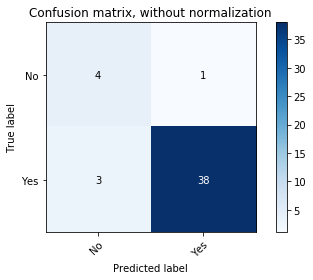

In [54]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
   # else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

class_names=['No','Yes']
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()

In [55]:
X = np.concatenate((X_train,X_test))

In [56]:
len(X)

370

In [57]:
X=X.reshape(X.shape[0],)

In [59]:
#y_test=y_test.reshape(y_test.shape[0],1)

In [60]:
y = np.concatenate((y_train,y_test))

In [61]:
y=y.reshape(y.shape[0],)

In [62]:
from sklearn.model_selection import cross_validate
nb = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),])
cv_results = cross_validate(nb.fit(X, y), X, y,cv=5)

In [63]:
print(cv_results['test_score'])

[0.97 0.96 0.97 0.96 0.95]


### SGDClassifier

In [65]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))])

In [66]:
%%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test).round(2))
print('f1-score %s' % f1_score(y_pred, y_test,average='weighted').round(2))
print(classification_report(y_test, y_pred))

accuracy 0.96
f1-score 0.96
             precision    recall  f1-score   support

          0       0.80      0.80      0.80         5
          1       0.98      0.98      0.98        41

avg / total       0.96      0.96      0.96        46

Wall time: 3.98 ms


In [67]:
sgd = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),])
cv_results = cross_validate(sgd.fit(X, y), X, y,cv=5)
print(cv_results['test_score'])

[1.   0.96 1.   1.   0.97]


### Logistic regression

In [68]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [69]:
%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test).round(2))
print('f1-score %s' % f1_score(y_pred, y_test,average='weighted').round(2))
print(classification_report(y_test, y_pred))

accuracy 0.98
f1-score 0.98
             precision    recall  f1-score   support

          0       1.00      0.80      0.89         5
          1       0.98      1.00      0.99        41

avg / total       0.98      0.98      0.98        46

Wall time: 2.51 ms


In [70]:
logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression(n_jobs=1, C=1e5))])
cv_results = cross_validate(logreg.fit(X, y), X, y,cv=5)
print(cv_results['test_score'])

[1.   1.   1.   1.   0.99]


In [71]:
from sklearn.ensemble import RandomForestClassifier

randomForest = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=100))
               ])
randomForest.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [72]:
%%time

y_pred = randomForest.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test).round(2))
print('f1-score %s' % f1_score(y_pred, y_test,average='weighted').round(2))
print(classification_report(y_test, y_pred))

accuracy 0.96
f1-score 0.96
             precision    recall  f1-score   support

          0       0.80      0.80      0.80         5
          1       0.98      0.98      0.98        41

avg / total       0.96      0.96      0.96        46

Wall time: 15.5 ms


# Feature importance plot using chi-square

In [75]:
from sklearn.feature_selection import chi2

tfidf = TfidfVectorizer(max_features=30000,ngram_range=(1, 3))
X_tfidf = tfidf.fit_transform(features_df['concat_text'])
#X_tfidf_no = tfidf.fit_transform(train_df_no['all_cols'])
y= features_df["tags"]
#y_no = train_df_no['Target']
chi2score = chi2(X_tfidf, y)[0]
#chi2score_no = chi2(X_tfidf_no, y_no)[0]

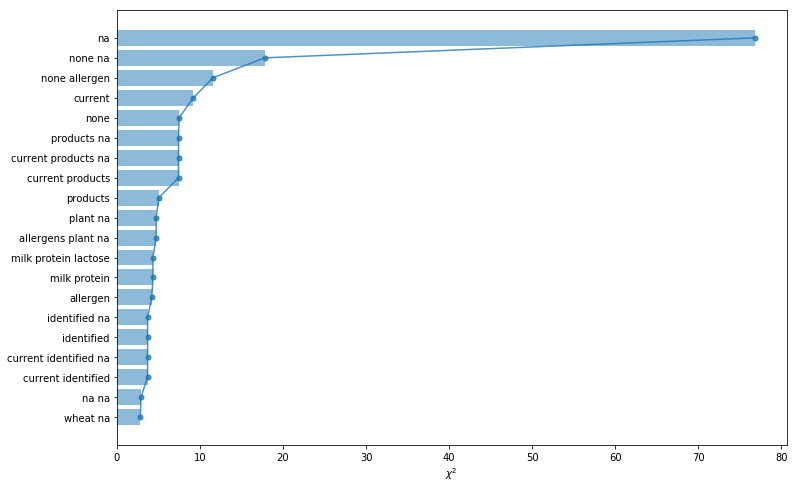

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
scores = list(zip(tfidf.get_feature_names(), chi2score))
#print(scores)
chi2 = sorted(scores, key=lambda x:x[1])
#print(chi2)
topchi2 = list(zip(*chi2[-20:]))
#print(topchi2)
x = range(len(topchi2[1]))
#print(x)
labels = topchi2[0]
#print(labels)
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();

# Further inspection

Let's look at the features our classifier is using to make decisions

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

#list_corpus = clean_questions["text"].tolist()
#list_labels = clean_questions["class_label"].tolist()

#X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
#                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [78]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [79]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

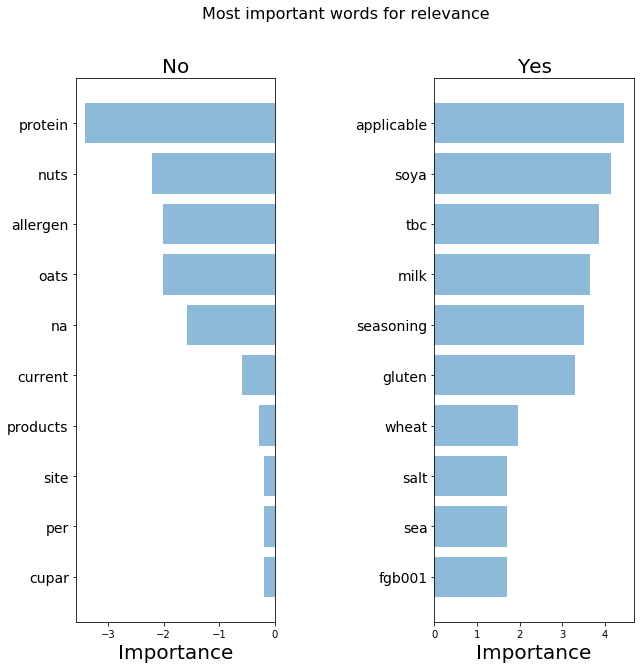

In [81]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('No', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Yes', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")